## [Dacon] AI프렌즈 시즌2 강수량 산출 경진대회
## giba.kim (팀명)
## 2020년 5월 29일 (제출날짜)

## 외부 데이터 수집 및 크롤링 코드

## 1. 라이브러리 및 데이터
## Library & Data

In [36]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import gc
import os

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

### 데이터 수집 방법

> 1. 사이트 접속 https://disc.gsfc.nasa.gov/
> 2. 회원 가입
> 3. Data 설명 PPT 7Page에 있는 GMI와 DPR Spec을 보고 날짜 설정 후 Download Link를 내려받습니다.

Download Link File 위치 정의

In [37]:
GMI_LINK_TXT = '../input/subset_GPM_1BGMI_05_20200522_110538.txt'
DPR_LINK_TXT = '../input/subset_GPM_2ADPR_06_20200522_145431.txt'

Orbit, 시간등 전처리<br>
다운로드 Link 예시<br>
https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L1B/GPM_1BGMI.05/2014/063/1B.GPM.GMI.TB2016.20140304-S175932-E193159.000079.V05A.HDF5

위 Link에서 날짜와 Orbit ID 추출<br>
1B.GPM.GMI.TB2016.20140304-S175932-E193159.000079.V05A.HDF5 <br>
1B.GPM.GMI.모름.날짜.시작시간-끝시간.Orbit..확장자 <br>

In [38]:
gmi_list_df = pd.read_csv(GMI_LINK_TXT, header=None,skiprows=2)
gmi_list_df.columns = ['URL']
dpr_list_df = pd.read_csv(DPR_LINK_TXT, header=None,skiprows=2)
dpr_list_df.columns = ['URL']

gmi_list_df['orbit'] = gmi_list_df['URL'].apply(lambda x: x.split('.')[-3])
dpr_list_df['orbit'] = dpr_list_df['URL'].apply(lambda x: x.split('.')[-3])

gmi_list_df['date'] = gmi_list_df['URL'].apply(lambda x: x.split('.')[-4].split('-')[0])
gmi_list_df["date"] = pd.to_datetime(gmi_list_df["date"])
gmi_list_df["year"] = gmi_list_df["date"].dt.year
gmi_list_df["month"] = gmi_list_df["date"].dt.month
gmi_list_df["day"] = gmi_list_df["date"].dt.day

dpr_list_df['date'] = dpr_list_df['URL'].apply(lambda x: x.split('.')[-4].split('-')[0])
dpr_list_df["date"] = pd.to_datetime(dpr_list_df["date"])
dpr_list_df["year"] = dpr_list_df["date"].dt.year
gmi_list_df["month"] = gmi_list_df["date"].dt.month
gmi_list_df["day"] = gmi_list_df["date"].dt.day

dpr에 있는 정보만 사용하도록 처리

In [39]:
gmi_list_df = gmi_list_df.loc[gmi_list_df['orbit'].isin(dpr_list_df['orbit'].unique())].reset_index(drop=True)

Test의 위경도 좌표만 데이터 추출하도록 제한

In [40]:
test = pd.read_feather('../input/test.ftr')
GMI_LONG_MIN = test['long_GMI'].min()
GMI_LONG_MAX = test['long_GMI'].max()
GMI_LAT_MIN = test['lat_GMI'].min()
GMI_LAT_MAX = test['lat_GMI'].max()
print(GMI_LONG_MIN, GMI_LONG_MAX, GMI_LAT_MIN, GMI_LAT_MAX)

118.66690063476562 176.3225860595703 4.450847148895264 55.80416488647461


In [41]:
def make_gmi_data(gmi_data, dpr_data, orbit, new_path):
    
    # HDF5 Type
    # 직접 수동으로 Sample orbit하나 지정 한 뒤 값 비교하면서 맞는 데이터 탐색 수행
    dpr_lat = np.array(dpr_data['NS']['Latitude']) # dpr Latitude
    dpr_long = np.array(dpr_data['NS']['Longitude']) # dpr Longitude
    dpr_rain = np.array(dpr_data['NS']['SLV']['precipRateNearSurface']) # 타겟값
    dpr_land = np.array(dpr_data['NS']['PRE']['landSurfaceType']) # Type

    gmi_tb = np.array(gmi_data["S1"]['Tb']) # Temp0~8
    gmi_lat = np.array(gmi_data["S1"]['Latitude']) # GMI Latitude
    gmi_long = np.array(gmi_data["S1"]['Longitude']) # GMI Longitude

    # gmi와 dpr의 센서 측정 범위가 다르기 때문에 gmi의 중심점을 기준으로 -20, +20만큼 데이터 가져오도록 설정
    # https://dacon.io/competitions/official/235591/talkboard/400589 에 센서 스펙 정보 나와있음
    gmi_col_min = int(np.round(gmi_lat.shape[1]/2)-20)
    gmi_col_max = int(np.round(gmi_lat.shape[1]/2)+20)
    
    dpr_col_count = dpr_lat.shape[1] # dpr의 Column Count, 데이터는 2차원 배열
    row_count = int(gmi_lat.shape[0]/40) # gmi Row Count, 40으로 나눠서 데이터에서 가능한 loop 개수 계산

    subset_num = 1
    for r in range(row_count):
        
        # 0부터 40, 40~80, 80~120 같이 40씩 증가시키면서 lat, long 정보 추출
        cur_gmi_lat = gmi_lat[r*40:(r+1)*40,gmi_col_min:gmi_col_max] 
        cur_gmi_long = gmi_long[r*40:(r+1)*40,gmi_col_min:gmi_col_max]
        
        # test의 위 경도 범위에 들어오지 않으면 제거
        if cur_gmi_lat.min()<GMI_LAT_MIN or GMI_LAT_MAX < cur_gmi_lat.max():
            continue
        if cur_gmi_long.min()<GMI_LONG_MIN or GMI_LONG_MAX < cur_gmi_long.max():
            continue
        
        sns.scatterplot(cur_gmi_long.reshape(-1),cur_gmi_lat.reshape(-1))
        
        # dpr과 gmi 위/경도 거리 계산
        m, n = np.meshgrid(dpr_lat, cur_gmi_lat)
        out1 = (m-n)**2
        del m, n
        
        m, n = np.meshgrid(dpr_long, cur_gmi_long)
        out2 = (m-n)**2
        del m, n
        
        out3 = np.sqrt(out1+out2)
        
        # 거리가 가장 가까운 Index를 계산하고 dpr의 column Count로 나눠서 2차원 배열로 만듬
        argmin = np.argmin(out3,axis=1)
        dpr_sr = (argmin/dpr_col_count).astype(int)
        dpr_sc = (argmin%dpr_col_count).astype(int)
        
        sns.scatterplot(dpr_long[dpr_sr,dpr_sc].reshape(-1),dpr_lat[dpr_sr,dpr_sc].reshape(-1), alpha=0.3)
        plt.title(f'{orbit}_{subset_num}')
        plt.show()
        
        # 주어진 data양식에 맞게 temp0~8, type, gmi_long, gmi_lat, dpr_long, dpr_lat, dpr_precip으로 concat
        new_data = np.concatenate([gmi_tb[r*40:(r+1)*40,gmi_col_min:gmi_col_max],
                        dpr_land[dpr_sr,dpr_sc].reshape(40,40,1),
                        cur_gmi_long.reshape(40,40,1),
                        cur_gmi_lat.reshape(40,40,1),
                        dpr_long[dpr_sr,dpr_sc].reshape(40,40,1),
                        dpr_lat[dpr_sr,dpr_sc].reshape(40,40,1),
                        dpr_rain[dpr_sr,dpr_sc].reshape(40,40,1)], axis=-1)
        
        # npy file로 저장
        print(new_data.shape, orbit, subset_num)
        new_file = new_path + '/' + f'subset_{orbit}_{subset_num}.npy'
        np.save(new_file, new_data)
        
        subset_num+=1
        
        del out1, out2, out3
        del new_data
        gc.collect()

### 2014, 2105 Request And Make

#### 대회 디렉토리 구조
├── **code** <br>
│   ├── best_model <br>
│   │   └── ... <br>
│   ├── savedmodel <br>
│   │   └── ... <br>
│   ├── requirements <br>
│   │   └── ... <br>
│   ├── epoch_result <br>
│   │   └── ... <br>
│   ├── segmentation_models_pytorch <br>
│   │   └── ... <br>
│   ├── DataConverter.ipynb <br>
│   ├── MakeNewData.ipynb <br>
│   └── ... <br>
└── **input** <br>
│   ├── train <br>
│   │   └── subset_010462_01.npy <br>
│   │   └── ... <br>
│   ├── test <br>
│   │   └── subset_010462_01.npy <br>
│   │   └── ... <br>
│   ├── newtrain <br>
│   │   └── subset_000148_1.npy <br>
│   │   └── ... <br>
│   ├── newdata <br>
│   │   └── ... <br>
└── **output** <br>
    └── ... <br>


Test의 5,6,7,8위주로 수집하였고 한꺼번에 여러개를 수집하기 위해 이 Notebook을 여러개 띄워서 사용하였습니다. <br>
2014~2015 연도에서 총 8581개를 더 수집하였습니다.<br>
month나 연도를 제한하여 download 받으시면 됩니다.<br>

hdf5 경로: ../input/newdata <br>
추가 데이터 경로: ../input/newtrain <br>
<br>

아래는 Python을 활용하여 Request하기 전에 설정해야되는 항목입니다.<br>
저희 팀은 windows에서 진행했고 .netrc 파일을 아래 방법처럼 설정하면 됩니다.<br>

https://disc.gsfc.nasa.gov/data-access<br>
Python using 'Requests'<br>
'Requests' is a popular Python library that simplifies Python access to Internet-based resources. In the following code, we demonstrate how to use 'Requests' to access GES DISC data using cookies created by a host operating system.

>1. Make sure you have setup your Earthdata account.
>2. **Create a .netrc file in your home directory.**<br>

>On **Windows**<br>
>a. 노트패드를 열고<br>
>b. 옆에 항목을 적습니다. 괄호는 빼고 적습니다. machine urs.earthdata.nasa.gov login <uid> password <password>
>c. 옆의 경로에 저장하는데 text로 저장하지말고 all files로 바꿔서 .netrc확장자로 저장합니다. 이름은 없어야 합니다. Save as: C:\Users\<username>\.netrc
    
>3. Install Requests library (we recommend version 2.22.0 or later).
>4. Download GES DISC data using the following Python3 code:


연도와 month를 선택하여 down 받을 list를 제한합니다.<br>
재현 시 저희가 받은 orbit list를 Load하여 Download 받습니다.<br>

In [42]:
newtrain = os.listdir('../input/newtrain/')
newtrain = pd.DataFrame(newtrain)
newtrain['orbit'] = newtrain[0].apply(lambda x: x.split('_')[1])

In [47]:
# gmi_2014_2015 = gmi_list_df.loc[gmi_list_df['year'].isin([2015])&(gmi_list_df['month']==5)]
gmi_2014_2015 = gmi_list_df.loc[gmi_list_df['orbit'].isin(newtrain['orbit'])]

너무 오래걸려서 중간에 멈추었는데 계속 받으면 계속 받을 수 있습니다.

https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L1B/GPM_1BGMI.05/2014/068/1B.GPM.GMI.TB2016.20140309-S041939-E055205.000148.V05A.HDF5
https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L2/GPM_2ADPR.06/2014/068/2A.GPM.DPR.V8-20180723.20140309-S041939-E055205.000148.V06A.HDF5


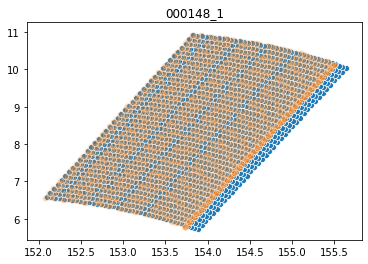

(40, 40, 15) 000148 1


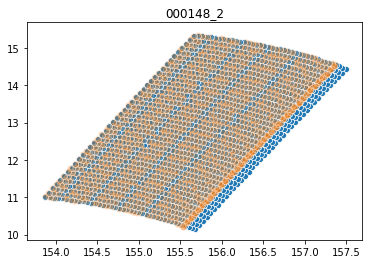

(40, 40, 15) 000148 2


KeyboardInterrupt: 

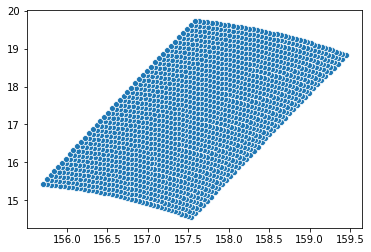

In [49]:
def get_data(url, filename):
    print(url)
    if os.path.exists(filename):
        return True
    
    result = requests.get(url)
    try:
        result.raise_for_status()
        f = open(filename,'wb')
        f.write(result.content)
        f.close()
    except KeyboardInterrupt:
        raise KeyboardInterrupt
    except:
        print('requests.get() returned an error code '+str(result.status_code))
        return False
    else:
        print('contents of URL written to '+filename)
        
        del result
        gc.collect()
        return True
        

for i, row in gmi_2014_2015.iterrows():
    orbit = row['orbit']
    try:
        dpr_temp = dpr_list_df.loc[dpr_list_df['orbit']==orbit]
        if dpr_temp.shape[0] == 0:
            print(oribt)
            continue

        gmi_url = row['URL']
        gmi_filename = '../input/newdata/' + gmi_url.split('/')[-1]
        if not get_data(gmi_url, gmi_filename):
            raise Exception("Failed Get GMI: ", orbit)

        dpr_url = dpr_temp['URL'].values[0]
        dpr_filename = '../input/newdata/' + dpr_url.split('/')[-1]
        if not get_data(dpr_url, dpr_filename):
            raise Exception("Failed Get DPR: ", orbit)

        gmi_data = h5py.File(gmi_filename, 'r')
        dpr_data = h5py.File(dpr_filename, 'r')
        make_gmi_data(gmi_data, dpr_data, orbit, '../input/newtrain')
        
        del gmi_data
        del dpr_data
        gc.collect()
    except KeyboardInterrupt:
        raise
    except:
        print("Exception!!", orbit)